# Restaurant Rating prediction project

## Import libraries and data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import re
import datetime
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import collections
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [4]:
#loading data
df = pd.read_csv('main_task.xls')
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
df.columns = ['Restaurant_id', 'City', 'Cuisine_style', 'Ranking', 'Rating', 
              'Price_range', 'Number_of_reviews', 'Reviews', 'URL_TA', 'ID_TA']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine_style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price_range        26114 non-null  object 
 6   Number_of_reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Exploration and Cleaning

# City

In [ ]:
# number of cities represented in the dataset
df['City'].value_counts().count()

31

<AxesSubplot:xlabel='City', ylabel='Rating'>

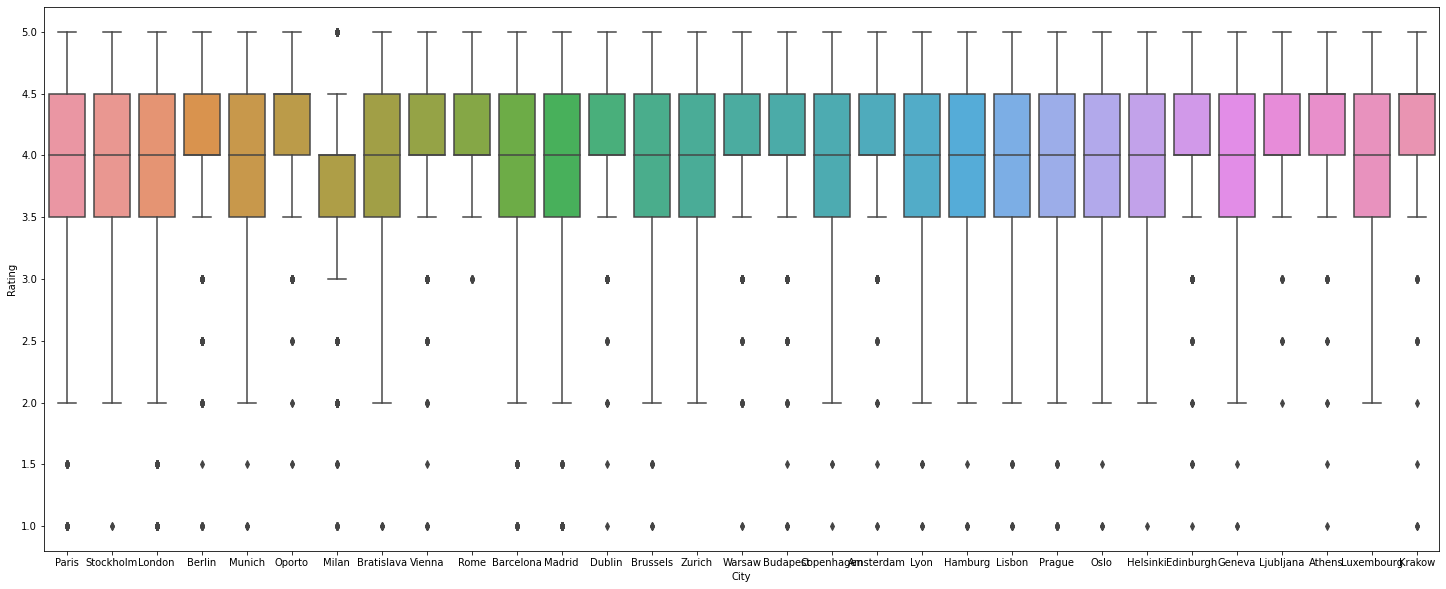

In [ ]:
fig = plt.figure(figsize=(25, 10))

sns.boxplot(x=df['City'], y=df['Rating'])

<AxesSubplot:>

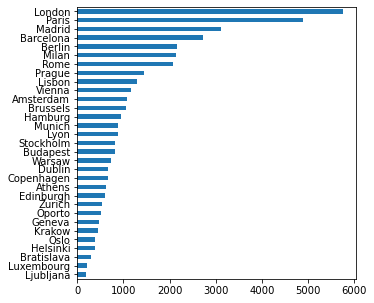

In [ ]:
# Cities distribution
df['City'].value_counts(ascending=True).plot(kind='barh', figsize=(5, 5))

In [ ]:
df = pd.get_dummies(df, columns=['City'])

# Cuisine_style

In [ ]:
# let's find unique values of cuisines 
def to_list(x):
    c_list = x.replace('[', '').replace(']', '').replace(
        "'", '').replace(', ', ',').split(',')
    return c_list


list_of_lists = df[~df.Cuisine_style.isna()]['Cuisine_style'].apply(to_list)
cuisine_list = []
for i in list_of_lists:
    cuisine_list.extend(i)
cuisine_list_fin = set(cuisine_list)  # dropped duplicates
len(cuisine_list_fin)

125

In [ ]:
# Let's find the 10 most popular cuisines that are represented in the largest number of restaurants
import collections
from collections import Counter
Dict = Counter(cuisine_list)
print(Dict.most_common(10))

[('Vegetarian Friendly', 11189), ('European', 10060), ('Mediterranean', 6277), ('Italian', 5964), ('Vegan Options', 4486), ('Gluten Free Options', 4113), ('Bar', 3297), ('French', 3190), ('Asian', 3011), ('Pizza', 2849)]


In [ ]:
# generating a new feature based on the number of cuisines in each restaurant:

def count_cuis(c_list):
    count = 0
    for row in c_list:
        if row != 'none':
            count += 1
        else:
            count = 1
    return count


df['Cuisine_style'] = df['Cuisine_style'].fillna('Vegetarian Friendly')#filling blanks with the most popular cuisine
df['Cuisine_style'] = df['Cuisine_style'].apply(to_list)
df['cuisine_count'] = df['Cuisine_style'].apply(count_cuis)

<AxesSubplot:>

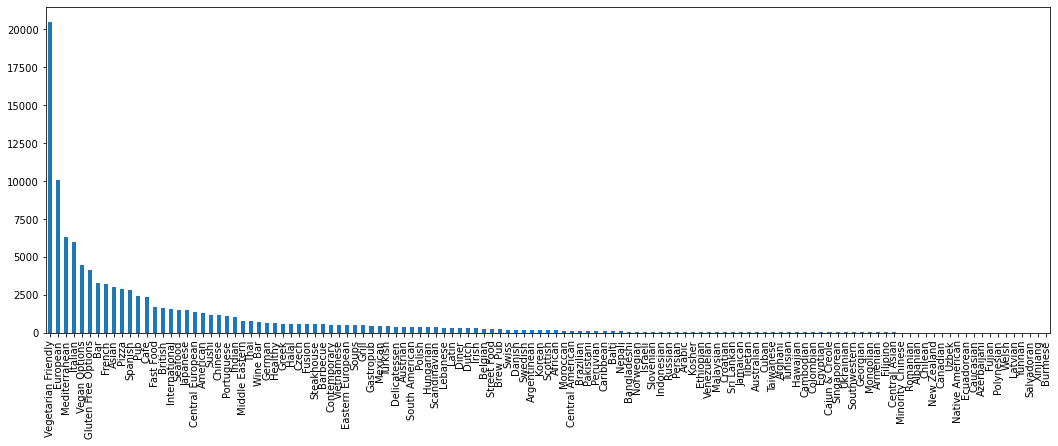

In [ ]:
# checking the most popular cuisines
plt.figure(figsize=(18, 6))
df.explode('Cuisine_style')['Cuisine_style'].value_counts(ascending=False).plot(kind='bar')

Let's take 10 most popular cuisines and define them in the dataset as 1, all the rest - 0

In [ ]:
pop_cuisines = ['Vegetarian Friendly', 'European', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options',
                'Bar', 'French', 'Asian', 'Pizza']


def count_cuisines(line):
    for x in line:
        if x in pop_cuisines:
            return 1
        else:
            return 0


df['Cuisine_style'] = df['Cuisine_style'].apply(count_cuisines)

# Reviews

In [7]:
# set a pattern for date search
pattern = re.compile('\d{2}\/\d{2}\/\d{4}')
# Find all values that match the pattern
df['reviews_date'] = df['Reviews'].apply(
    lambda x: x == 'no_date' if x == [] else pattern.findall(x))
df['reviews_date'].head(5)

0    [12/31/2017, 11/20/2017]
1    [07/06/2017, 06/19/2016]
2    [01/08/2018, 01/06/2018]
3                          []
4    [11/18/2017, 02/19/2017]
Name: reviews_date, dtype: object

In [8]:
# Generate a new feature 'the year of the last review'
len_rev = len(df['reviews_date'])
years = []
for i in range(0, len_rev):
    one_list = df['reviews_date'][i]
    if len(one_list) == 2:
        date1 = pd.to_datetime(one_list[0], format='%m/%d/%Y')
        year = date1.year
    else:
        year = 0  # gaps will be replaced by 0
    years.append(year)

df['year_of_last_review'] = years

In [9]:
df['year_of_last_review'].value_counts()

2017    20566
0       11027
2018     4130
2016     2895
2015      882
2014      272
2013      139
2012       61
2011       11
2008        8
2010        7
2009        2
Name: year_of_last_review, dtype: int64

Our main distribution is in 2017, so we will replace 2017 with 0

In [10]:
df.loc[df['year_of_last_review'] == 0, 'year_of_last_review'] = 2017

<AxesSubplot:ylabel='Frequency'>

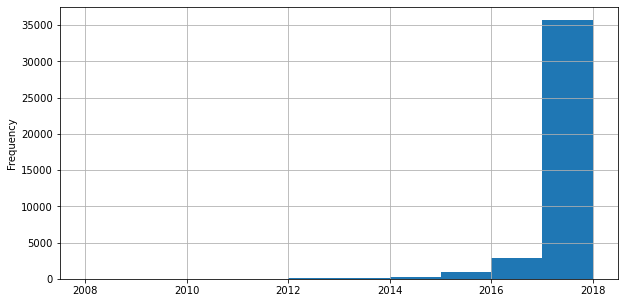

In [ ]:
df['year_of_last_review'].plot(kind='hist', grid=True, figsize=(10, 5))

In [ ]:
df['year_of_last_review'].describe()

count    40000.000000
mean      2016.939775
std          0.673060
min       2008.000000
25%       2017.000000
50%       2017.000000
75%       2017.000000
max       2018.000000
Name: year_of_last_review, dtype: float64

In [ ]:
len(df[df['year_of_last_review'] > 2016])

35723

Fresh reviews have more weight than those written long ago. Relevance plays a big role: a large number of recent reviews will be rated higher than those that are several years old. Most of our reviews are from 2016-2018. Let's create a feature indicating how long ago the review was left

In [11]:
def change_years(x):
    if x > 2016:
        return 1
    else:
        return 0

df['year_of_last_review'] = df['year_of_last_review'].apply(change_years)

In [12]:
# What is the maximum number of days between the publication dates of reviews posted on the restaurant website?
len_rev = len(df['reviews_date'])
diff = []
for i in range(0, len_rev):
    one_list = df['reviews_date'][i]
    if len(one_list) == 2:
        date1 = pd.to_datetime(one_list[0], format='%m/%d/%Y')
        date2 = pd.to_datetime(one_list[1], format='%m/%d/%Y')
        date = (date1-date2).days
    else:
        date = 0
    diff.append(date)  # found the difference in days between reviews
print(max(diff))

3207


In [13]:
# Let's generate a new feature from the new information:
df['delta_days'] = diff
df.head(3)

,Restaurant_id,City,Cuisine_style,Ranking,Rating,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,reviews_date,year_of_last_review,delta_days
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",1,41
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",1,382
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",1,2


1946

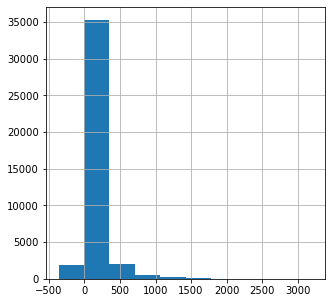

In [ ]:
# checking the distribution:
df['delta_days'].hist(figsize=(5, 5))
len(df[df['delta_days'] < 0])

In [14]:
# Let's generate a new feature from the new information. Looking at the feature distribution plot, 
# we can observe that we also have negative values, which logically should not be there. Let's replace them with 0:
df.loc[df['delta_days'] < 0, 'delta_days'] = 0

In [15]:
# look at the outliers borders
IQR = df.delta_days.quantile(0.75) - df.delta_days.quantile(0.25)
perc25 = df.delta_days.quantile(0.25)
perc75 = df.delta_days.quantile(0.75)

print(
    '25th percentile: {},'.format(perc25),
    '75th percentile: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "outliers borders: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25th percentile: 0.0, 75th percentile: 105.0, IQR: 105.0,  outliers borders: [-157.5, 262.5].


In [ ]:
# smooth out outliers
df.loc[df['delta_days'] > 1000, 'delta_days'] = 1000

<AxesSubplot:>

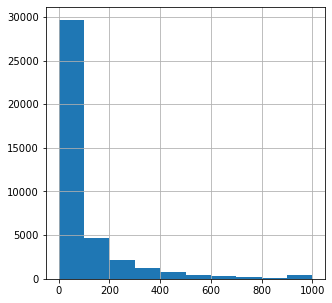

In [ ]:
df['delta_days'].hist(figsize=(5, 5))

In [ ]:
df['delta_days'].describe()

count    40000.000000
mean        92.363000
std        170.526054
min          0.000000
25%          0.000000
50%         20.000000
75%        105.000000
max       1000.000000
Name: delta_days, dtype: float64

Let's create a feature that counts "good or bad" reviews

In [ ]:
def get_list_rev(x):
    x = x.replace('[', '').replace(']', '').replace(
        "'", '').replace(', ', ',').split(',')[0:2]
    list_words = []
    for elem in x:
        list_words.extend(elem.split())
    return list_words


word_r = {'good_r': ['good', 'best', 'wonderful', 'unique', 'nice', 'amazing', 'excellent ', 'great', 'lovely',
                     'healthy', 'delicious', 'traditional', 'funny', 'historic', 'friendly', 'fresh', 'cheap', 'liked',
                     'heavenly', 'fast', 'not bad', 'unusual', 'cool', 'outstanding', 'love', 'fantastic', 'tasty', 'cozy',
                     'quiet', 'better', 'super', 'well', 'yummy', 'real', 'cute', 'atmosphere', 'fabulous', 'marvelous', 'decent',
                     'generous', 'superb'],
          'bad_r': ['not', 'cold', 'mediocre', 'unfriendly', 'dreadful', 'disappointed''terrible', 'average', 'rude', 'worst',
                    'nothing', 'foo', 'bad', 'poor', 'stop', 'worst', 'disappointing', 'overpriced', 'horrible', 'worse', 'dirty',
                    'waste', 'satisfying', 'disappointment']}


def get_review(reviews):
    count_good = 0
    for review in reviews:
        for elem in word_r['good_r']:
            if elem == review.lower():
                count_good += 1
        for elem in word_r['bad_r']:
            if elem == review.lower():
                count_good -= 1

    return(count_good)


df['Reviews'] = df['Reviews'].apply(get_list_rev)
df['good_reviews'] = df['Reviews'].apply(get_review)
df[['Reviews', 'good_reviews']]

,Reviews,good_reviews
0,"[Good, food, at, your, doorstep, A, good, hote...",2
1,"[Unique, cuisine, Delicious, Nepalese, food]",2
2,"[Catch, up, with, friends, Not, exceptional]",-1
3,[],0
4,"[Best, place, to, try, a, Bavarian, food, Nice...",2
...,...,...
39995,"[The, real, Italian, experience!, Wonderful, f...",2
39996,"[Parisian, atmosphere, Bit, pricey, but, inter...",1
39997,"[Good, by, swedish, standards, A, hidden, jewe...",1
39998,"[Underground, restaurant, Oldest, Restaurant, ...",0


# Restaurant_id

In [ ]:
df['Restaurant_id'].value_counts()

id_227      18
id_871      18
id_436      18
id_633      18
id_344      17
            ..
id_11037     1
id_15485     1
id_11358     1
id_13037     1
id_4857      1
Name: Restaurant_id, Length: 11909, dtype: int64

Note that some restaurants are more common than others. This may indicate that there are chain restaurants in the dataset among all.

In [ ]:
# creating a feature indicating restaurant's belonging to the chain (1-chain, 0-not)
c_rests = list(df.Restaurant_id.value_counts()[
               df.Restaurant_id.value_counts() > 1].index)
df['c_rest'] = df[df.Restaurant_id.isin(
    c_rests)].Restaurant_id.apply(lambda x: 1)
df['c_rest'].fillna(0, inplace=True)
df.c_rest = df.c_rest.astype(int)

In [ ]:
df.c_rest.value_counts()

1    35295
0     4705
Name: c_rest, dtype: int64

There are much more chain restaurants!

# Price_range

In [ ]:
# Fill missing values with the most common ones
df['Price_range'].value_counts()
df['Price_range'] = df['Price_range'].fillna('$$ - $$$')

In [ ]:
# Let's replace quantitative indicators with numerical ones
dict_price = {'$': 1, '$$ - $$$': 2, '$$$$': 3}


def change(x):
    for key in dict_price:
        if key == x:
            return dict_price[key]


df.Price_range = df.Price_range.apply(change)
df.sample(3)

,Restaurant_id,Cuisine_style,Ranking,Rating,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,City_Amsterdam,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,cuisine_count,reviews_date,year_of_last_review,delta_days,good_reviews,c_rest
4163,id_8892,0,8894.0,3.5,2,117.0,"[Incredible, like, French, refined, cuisine, ""...",/Restaurant_Review-g187147-d1819766-Reviews-Sh...,d1819766,0,...,0,0,0,0,2,"[03/17/2017, 10/12/2016]",1,156,-1,0
38603,id_8664,0,8673.0,4.0,1,9.0,"[Lovely, little, place, Good, British, Breakfast]",/Restaurant_Review-g186338-d3863573-Reviews-Ca...,d3863573,0,...,0,0,0,0,1,"[03/30/2017, 03/26/2017]",1,4,2,1
16701,id_2491,1,2496.0,3.0,2,3.0,[],/Restaurant_Review-g187331-d12089363-Reviews-S...,d12089363,0,...,0,0,0,0,1,[],1,0,0,1


# Ranking

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

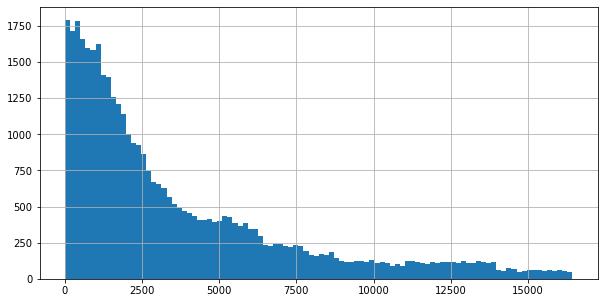

In [ ]:
df['Ranking'].hist(bins=100, figsize=(10, 5))
df['Ranking'].describe()

Most of the restaurants are from 1-3000 place in their city. Let's look at the ranking

<AxesSubplot:>

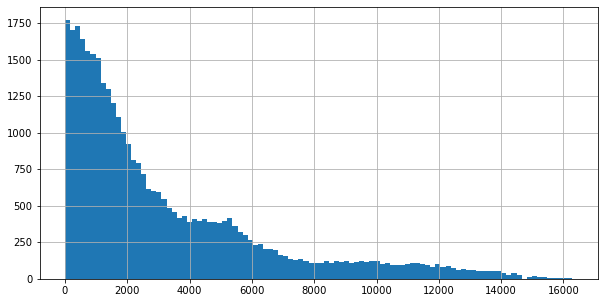

In [ ]:
df['Ranking'][df['Rating'] > 3].hist(bins=100, figsize=(10, 5))

We can observe that many restaurants with a rating of 4 or 5 have a good place in the rating in the city

In [ ]:
#scale down the data using normalization
scaler = MinMaxScaler()
df.Ranking = scaler.fit_transform(np.array(df.Ranking).reshape(-1,1))#convert it to an array and make it two-dimensional.
df.Ranking

0        0.338685
1        0.093414
2        0.021407
3        0.210241
4        0.037706
           ...   
39995    0.030347
39996    0.385574
39997    0.100407
39998    0.038922
39999    0.293499
Name: Ranking, Length: 40000, dtype: float64

# Number_of_reviews

In [ ]:
# Replace gaps with mean value of the column "Number_of_reviews"
mean_numb = df['Number_of_reviews'].mean()
df['Number_of_reviews'] = df['Number_of_reviews'].fillna(mean_numb).astype(int)

count    40000.000000
mean       124.773000
std        286.113363
min          2.000000
25%         10.000000
50%         38.000000
75%        124.000000
max       9660.000000
Name: Number_of_reviews, dtype: float64

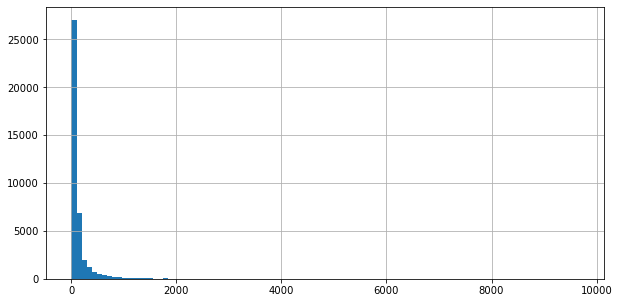

In [ ]:
df.Number_of_reviews.hist(bins=100, figsize=(10, 5))
df.Number_of_reviews.describe()

In [ ]:
df.head(3)

,Restaurant_id,Cuisine_style,Ranking,Rating,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,City_Amsterdam,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,cuisine_count,reviews_date,year_of_last_review,delta_days,good_reviews,c_rest
0,id_5569,1,0.338685,3.5,2,194,"[Good, food, at, your, doorstep, A, good, hote...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,...,0,0,0,0,3,"[12/31/2017, 11/20/2017]",1,41,2,1
1,id_1535,1,0.093414,4.0,2,10,"[Unique, cuisine, Delicious, Nepalese, food]",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,...,1,0,0,0,1,"[07/06/2017, 06/19/2016]",1,382,2,1
2,id_352,0,0.021407,4.5,3,688,"[Catch, up, with, friends, Not, exceptional]",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,...,0,0,0,0,7,"[01/08/2018, 01/06/2018]",1,2,-1,1


<AxesSubplot:>

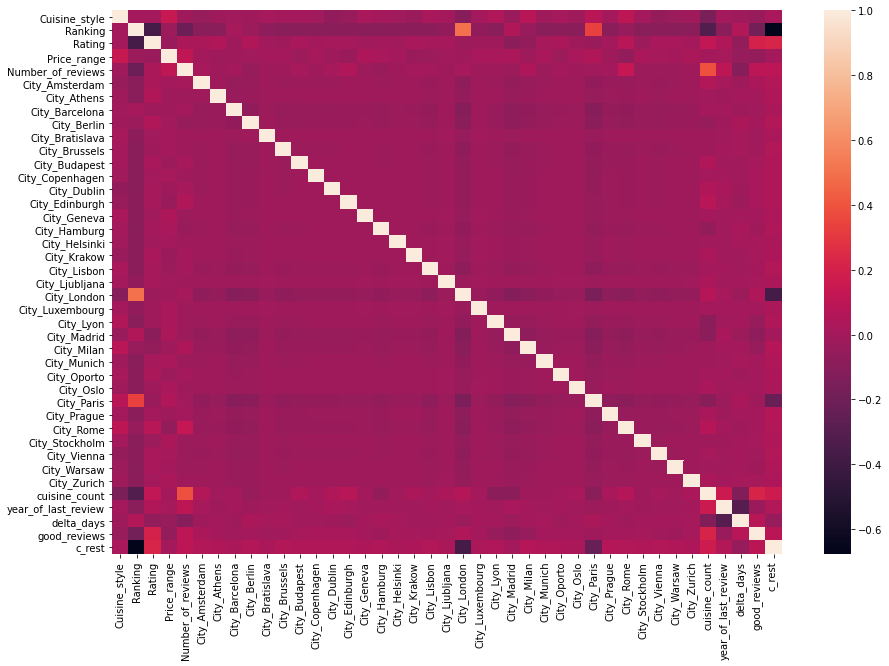

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr())

## We split the dataframe into parts necessary for training and testing the model

In [ ]:
# Х - restaurants info, у - target value (restaurant rating)
X = df.drop(['Restaurant_id','Rating','Reviews', 'URL_TA', 'ID_TA','reviews_date'], axis=1)
y = df['Rating']

In [ ]:
# Download a special tool for splitting:
from sklearn.model_selection import train_test_split

In [ ]:
# Datasets labeled "train" will be used for training the model, "test" is for testing.
# we will use 25% of the original dataset for testing,.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [ ]:
# Import the necessary libraries:
# tool for creating and training a model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # tools for evaluating model accuracy

In [ ]:
# creating a model
regr = RandomForestRegressor(n_estimators=100)

# Train the model on the test dataset
regr.fit(X_train, y_train)

# predicting:
y_pred = regr.predict(X_test)

In [ ]:
# We compare the predicted values (y_pred) with the real ones (y_test), and see how they differ on average
# Mean Absolute Error (MAE) shows the average deviation of the predicted values from the actual ones.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21392799999999998


<AxesSubplot:>

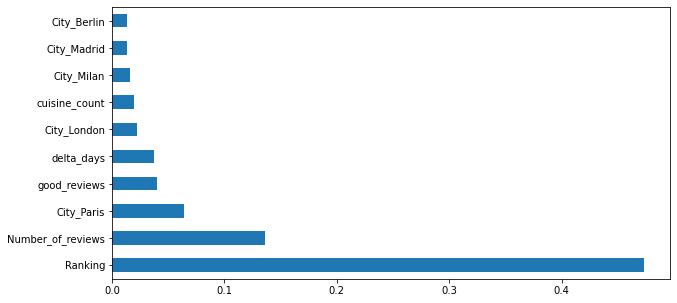

In [ ]:
# look at the most important features for the model
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

According to the plot, we can see that the "Ranking" feature affects 'Rating' the most.